# Grover's Algorithm

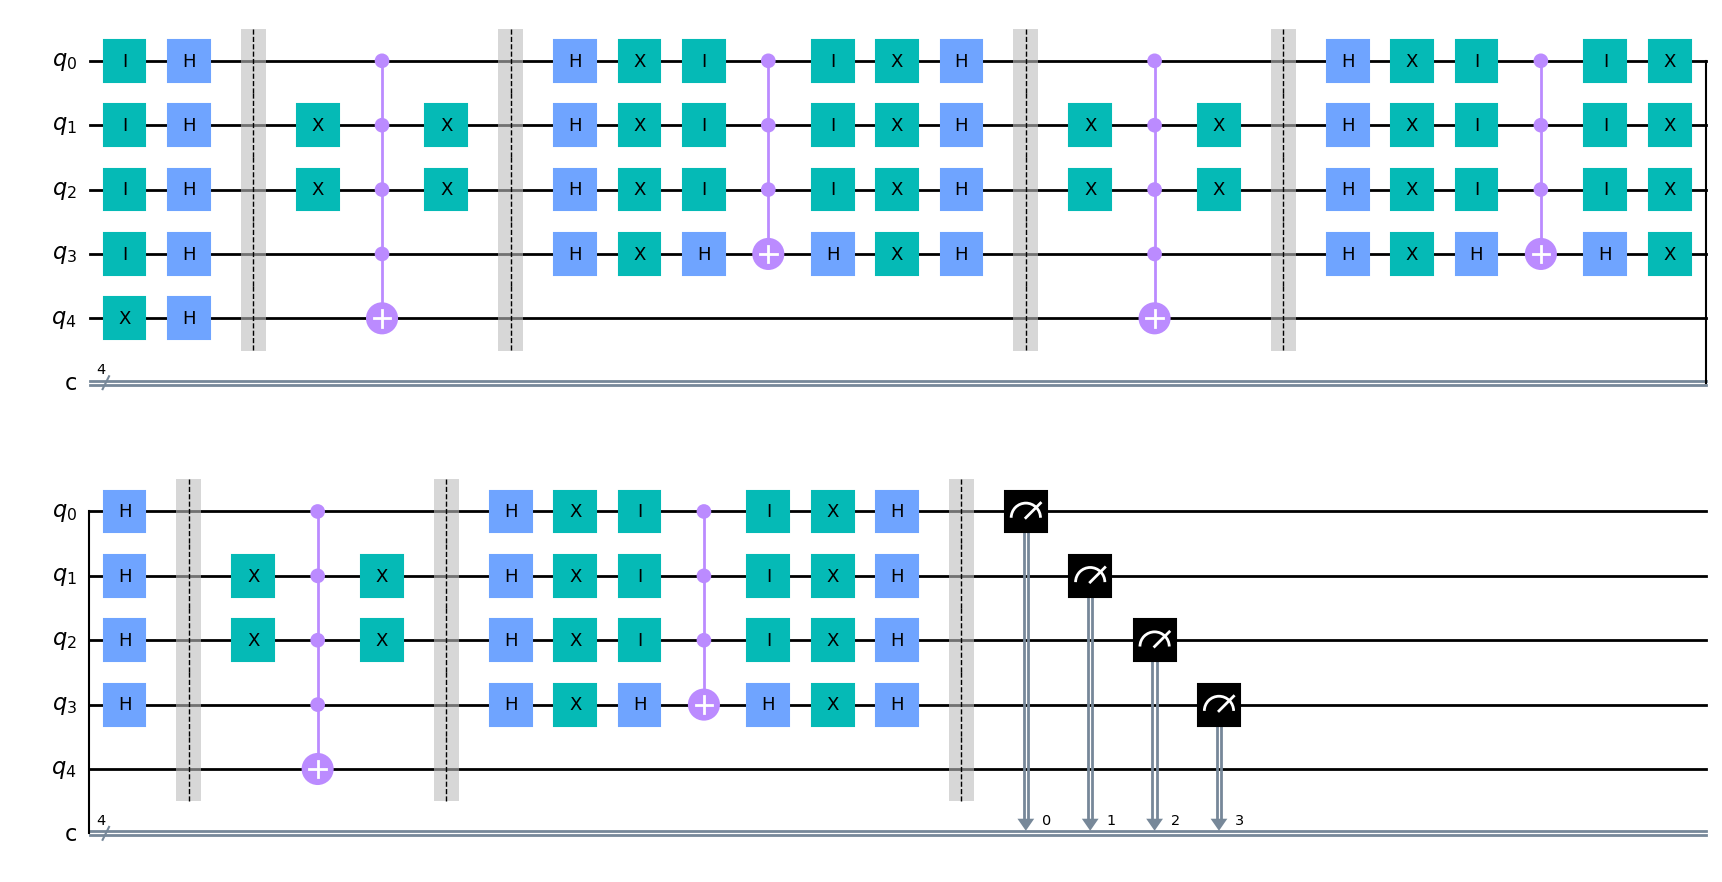

In [73]:
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit.library import *
import math

%matplotlib inline

def oracle(s, n, circuit):    
    # Read state to be encoded
    for i in range(n):
        # We add a NOT gate wherever 0s exist
        if str(s)[i] == "0":
            circuit.x(i)
            
    circuit.append(C4XGate(), [
        circuit.qregs[0][0], 
        circuit.qregs[0][1], 
        circuit.qregs[0][2], 
        circuit.qregs[0][3], 
        circuit.qregs[0][4]
    ])
    
    for i in range(n):
        if str(s)[i] == "0":
            circuit.x(i)    
    
def diffuser(s, n, circuit):
    circuit.h([i for i in range(n)])
    circuit.x([i for i in range(n)])
    circuit.id([i for i in range(n-1)])
    
    # Triply Controlled Z Gate
    circuit.h(n-1)
    circuit.append(C3XGate(), [
        circuit.qregs[0][0], 
        circuit.qregs[0][1], 
        circuit.qregs[0][2], 
        circuit.qregs[0][3]
    ])
    circuit.h(n-1)
    
    circuit.id([i for i in range(n-1)])
    circuit.x([i for i in range(n)])
    circuit.h([i for i in range(n)])

# Binary string to be found
s = 1001

# Get number of digits and calculate number of elements in db
n = len(str(s))
N = 2**n

# Create circuit with n+1 qubits
circuit = QuantumCircuit(n+1,n)

# Add identity gates on the unaffected qubits
circuit.id([i for i in range(n)])

# Set oracle qubit to state |1>
circuit.x(n)

# Apply Hadamard gates on all qubits
circuit.h([i for i in range(n+1)])

for _ in range(math.ceil(math.pi/4*math.sqrt(N)-1)):
    circuit.barrier()
    oracle(s, n, circuit)
    circuit.barrier()
    diffuser(s, n, circuit)

circuit.barrier()

circuit.measure([i for i in range(n)], [i for i in range(n)])

# circuit.draw("mpl")
circuit.draw("mpl")


# Executing on Quantum Simulator

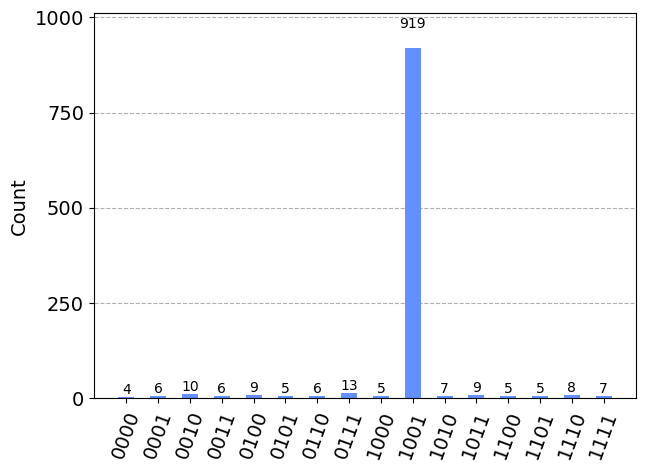

In [66]:
# Run on qiskit simulator
sim = Aer.get_backend("qasm_simulator")
res = execute(circuit, backend=sim, shots=1024).result()
counts = res.get_counts()
plot_histogram(res.get_counts(circuit))

# Executing on Quantum Computer

ibmqfactory.load_account:WARNING:2024-06-02 19:32:57,667: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


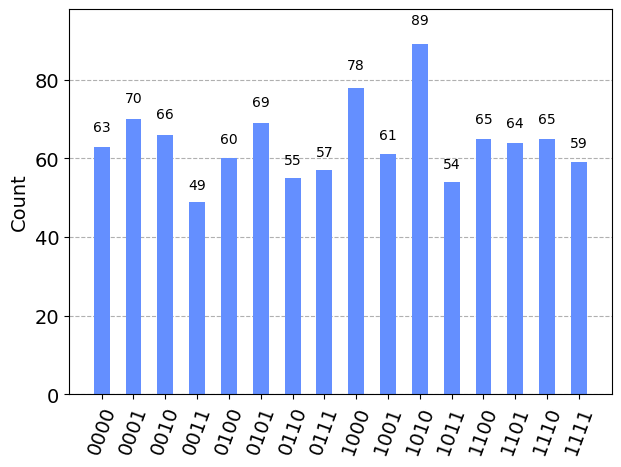

In [75]:
from qiskit.tools.monitor import job_monitor

# Load account settings from previous experiments
IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q')

# Choose machine
device = provider.get_backend('ibm_brisbane')

# Queue up job (avg. expected time ~ 1hr)
job = execute(circuit,backend = device,shots = 1024)
job_monitor(job)

device_result = job.result()

plot_histogram(device_result.get_counts(circuit))